In [14]:

import torch.nn as nn
import os
import torch.nn.functional as F
from collections import Counter
from torchvision import transforms, datasets
import torchvision
import torchmetrics
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
import time
import logging
import pandas as pd
from helper import *

In [3]:
BATCH_SIZE = 256
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
NUM_WORKERS = 10 

In [4]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [5]:
device = set_device()

PyTorch version: 2.2.2
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [6]:
train_transform = transforms.Compose([
           torchvision.transforms.ToTensor(),
           torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        
test_transform = transforms.Compose([
              torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]) 

train_dataset = datasets.CIFAR10(root = '../../data', 
                                 train = True, 
                                 transform = train_transform, 
                                 download = True)

test_dataset = datasets.CIFAR10(root = '../../data', 
                                train = False, 
                                transform = test_transform, 
                                download = True)
    

train_dataloader = DataLoader(train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True,
                              num_workers = NUM_WORKERS, 
                              drop_last = True)


test_dataloader = DataLoader(test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False, 
                            num_workers = NUM_WORKERS, 
                             drop_last = True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
class_names = train_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Image Shape: torch.Size([256, 3, 32, 32])
Lables shape: torch.Size([256]) 


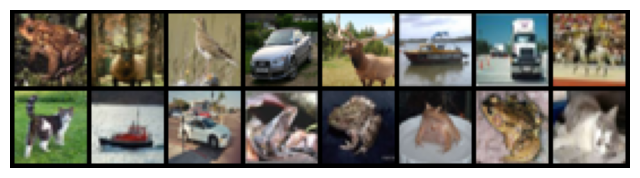

In [8]:
img, label = next(iter(train_dataloader))

print(f"Image Shape: {img.shape}")
print(f"Lables shape: {label.shape} ")


plt.figure(figsize = (8,8))
plt.axis("off")
plt.imshow(np.transpose(torchvision.utils.make_grid(img[:16], padding = 2, normalize= True), (1, 2, 0 )))
plt.show()

In [9]:
len(train_dataset), len(test_dataset)

(50000, 10000)

In [11]:
class PyTorchVGG16(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1), 
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),    
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))             
        )
        
        self.features = nn.Sequential(
            self.block_1, self.block_2, 
            self.block_3, self.block_4, 
            self.block_5
        )
            
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
                     
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                #n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                #m.weight.data.normal_(0, np.sqrt(2. / n))
                m.weight.detach().normal_(0, 0.05)
                if m.bias is not None:
                    m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                m.weight.detach().normal_(0, 0.05)
                m.bias.detach().detach().zero_()
        
    def forward(self, x):

        x = self.features(x)
        # x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)

        return logits

In [12]:
from tqdm import tqdm

def train(model, train_dataloader, test_dataloader, epochs, criterion, optimizer, device, scheduler = None):
    """
    This function trains the model
    
    Parameters
    ----------
    model: nn.Module
    train_dataloader: DataLoader
    test_dataloader: DataLoader
    epochs: int
    criterion: nn.Module
    optimizer: nn.Module
    device: str
    """
    
    model.to(device)
    
    results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in tqdm(range(epochs)):
        model.train()
        training_loss, training_acc = 0.0, 0.0
        
        for batch, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            training_acc += (outputs.argmax(1) == labels).float().mean()
            training_acc = training_acc.item()
            
        scheduler.step()
        epoch_loss_tr = training_loss / len(train_dataloader)
        epoch_acc_tr = training_acc / len(train_dataloader)
        
        logger.info(f'Epoch: {epoch} Training Loss: {epoch_loss_tr}, Training Accuracy: {epoch_acc_tr}')
        
        model.eval()
        test_loss, test_acc = 0.0, 0.0
        
        for batch, (inputs, labels) in enumerate(test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            test_acc += (outputs.argmax(1) == labels).float().mean()
            test_acc = test_acc.item()
            
        epoch_loss_te = test_loss / len(test_dataloader)
        epoch_acc_te = test_acc / len(test_dataloader)
        
        logger.info(f'Epoch: {epoch} Validation Loss: {epoch_loss_te}, Validation Accuracy: {epoch_acc_te}')
    
        results['train_loss'].append(epoch_loss_tr)
        results['train_acc'].append(epoch_acc_tr)
        results['val_loss'].append(epoch_loss_te)
        results['val_acc'].append(epoch_acc_te)
        
    return model, results

In [13]:
pytorch_model = PyTorchVGG16(num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pytorch_model.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.1)

pytorch_model, results = train(pytorch_model, train_dataloader, test_dataloader, NUM_EPOCHS, criterion, optimizer, device, scheduler)

  0%|          | 0/5 [00:00<?, ?it/s]2024-04-04 11:57:29,223 - __main__ - INFO - Epoch: 0 Training Loss: 7.166048055428725, Training Accuracy: 0.21604567307692307
2024-04-04 11:58:33,635 - __main__ - INFO - Epoch: 0 Validation Loss: 1.663744519918393, Validation Accuracy: 0.3851161858974359
 20%|██        | 1/5 [02:36<10:24, 156.11s/it]2024-04-04 12:00:00,141 - __main__ - INFO - Epoch: 1 Training Loss: 1.5462832463093292, Training Accuracy: 0.41901041666666666
2024-04-04 12:01:04,555 - __main__ - INFO - Epoch: 1 Validation Loss: 1.443863673087878, Validation Accuracy: 0.45923477564102566
 40%|████      | 2/5 [05:07<07:39, 153.05s/it]2024-04-04 12:02:31,340 - __main__ - INFO - Epoch: 2 Training Loss: 1.4549123427806756, Training Accuracy: 0.45753205128205127
2024-04-04 12:03:35,931 - __main__ - INFO - Epoch: 2 Validation Loss: 1.4248110911785028, Validation Accuracy: 0.4700520833333333
 60%|██████    | 3/5 [07:38<05:04, 152.29s/it]2024-04-04 12:05:02,661 - __main__ - INFO - Epoch: 3 Tra

In [15]:
results_df = pd.DataFrame(results)
results_df

,train_loss,train_acc,val_loss,val_acc
0,7.166048,0.216046,1.663745,0.385116
1,1.546283,0.419010,1.443864,0.459235
2,1.454912,0.457532,1.424811,0.470052
3,1.441476,0.463121,1.421273,0.472756
4,1.440074,0.464403,1.421097,0.472957


100%|██████████| 39/39 [01:04<00:00,  1.65s/it]
/var/folders/vq/zk2fmtnd52x9shn3q484yglm0000gn/T/ipykernel_54345/2496706466.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


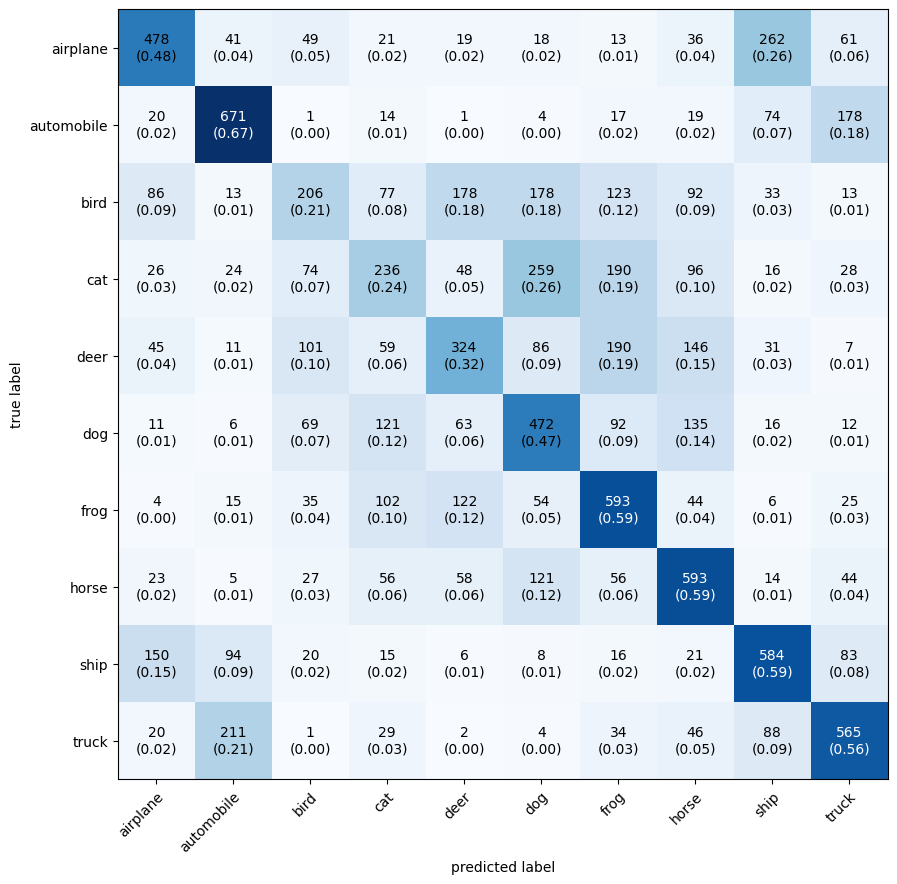

In [17]:
from tqdm import tqdm

y_preds = []

pytorch_model.eval()
with torch.inference_mode(): 
    for X, y in tqdm(test_dataloader): 
        X, y = X.to(device), y.to(device)
        logits = pytorch_model(X)
        pred = torch.argmax(logits, dim = 1)
        pred = pred.cpu()
        
        y_preds.append(pred)
        
y_preds = torch.cat(y_preds, dim = 0)
test_truth = torch.cat([y for _, y in test_dataloader], dim = 0 )

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass').to(device)
confmat_tensor = confmat(y_preds.to(device), test_truth.to(device))
confmat_tensor = confmat_tensor.cpu()

fig, ax = plot_confusion_matrix(confmat_tensor.numpy(), figsize=(10, 10), class_names=class_names, show_normed=True)
fig.show()